In [16]:
import numpy as np
from sndaq.analysis import AnalysisHandler, AnalysisConfig

## Setup Analyses and Storage

In [21]:
ana_conf = AnalysisConfig.from_config(conf_path='../../data/config/analysis.config')
ana = AnalysisHandler(config=ana_conf)

ndom = 5160
nbins_window = 400  # 200 s of rates in 0.5s bins
nbins_trigger = int((ana.config.duration_nosearch + 3*max(ana._binnings)) / 500 - 1)
nbins_fill_trailing = nbins_trigger - int(ana.config.duration_nosearch/2 /500)
nbins_fill_leading = nbins_trigger - nbins_fill_trailing - nbins_window

dom_bkg_mu = 140
dom_bkg_sig = 22

rate_500ms = np.zeros(shape=(nbins_window, ndom), dtype=np.uint16)
signi = np.zeros(shape=(nbins_window, len(ana.analyses)), dtype=float)

filler = None
np.random.seed(42)

## Generate samples

In [20]:
n_samples = 100
xi = np.zeros(n_samples)
for idx in range(n_samples):

    # Feed bins ahead of followup window
    for i in range(nbins_fill_trailing):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses()

    # Feed bins of followup window (100 s)
    for i in range(nbins_window):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses(rate)

    # Feed bins to align followup window with PySNDAQ's search windows
    for i in range(nbins_fill_leading):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses(rate)

    # Feed followup window through PySNDAQ's search window (Generate the TS)
    for i in range(nbins_window):
        rate = np.random.normal(dom_bkg_mu, dom_bkg_sig, size=ndom).astype(np.uint32)
        ana.buffer_analysis.append(rate)
        ana.update_analyses(rate)

        for j, analysis in enumerate(ana.analyses):
            signi[i, j]  = analysis.xi    
    xi[idx] = signi.max()

IndexError: index 1378 is out of bounds for axis 0 with size 1319

## Plot Results

Text(0.5, 1.0, 'Fit Results: $\\mu$=2.97, $\\sigma$=0.35')

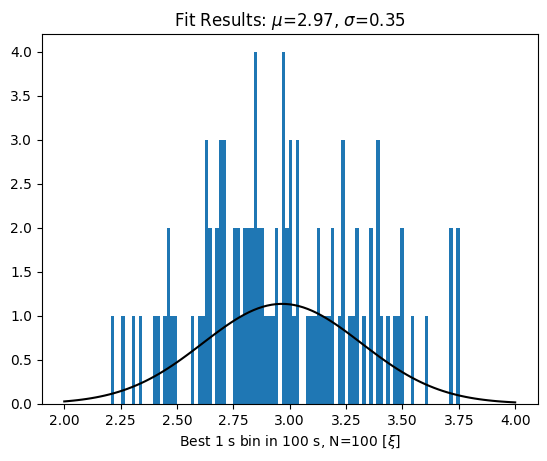

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean,std=norm.fit(xi)
x = np.linspace(2,4, 101)

plt.hist(xi, bins=100)
plt.plot(x, norm.pdf(x, loc=mean, scale=std), 'k')
plt.xlabel(fr"Best 1 s bin in 100 s, N={n_samples} [$\xi$]")
plt.title(fr"Fit Results: $\mu$={mean:4.2f}, $\sigma$={std:4.2f}")

## Profiling

Done with `%%timeit` IPython Magic function

With `binnings = [1000]` (2 binned analyses):
```
- 786 ms ± 87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

With default, `binnings = [500, 1500, 4000, 10000]` (32 binned analyses):
```
- 4.21 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [5]:
t_per_sample = 0.786  # seconds
runtime = t_per_sample * n_samples  # This is an estimate
ratio = runtime / ana.current_time

print(f"Real time: {runtime:.4f} s")
print(f"Processed time: {ana.current_time} s")
print(f"RtP Ratio: {ratio:.4f}")  # Ratio of real time to processed time, smaller is better

Real time: 78.6000 s
Processed time: 86250.0 s
RtP Ratio: 0.0009


## Debug

In [6]:
for i, (analysis, xi) in enumerate(zip(ana.analyses, signi.T), start=1):
    print(f"\nSearch #{i:<2d}: {analysis.binsize/1e3:<4.1f} +{analysis.offset/1e3:<4.1f}s\n"
          f"   max xi : {xi.max():4.2f}  @ bin t={xi.argmax()*0.5}s from window start")


Search #1 : 1.0  +0.0 s
   max xi : 2.70  @ bin t=36.5s from window start

Search #2 : 1.0  +0.5 s
   max xi : 2.54  @ bin t=8.5s from window start


## Sanity checks on background mean and rate variance (USE AS UNITTEST)

In [7]:
buffer = ana.buffer_analysis.data
for i, search in enumerate(ana.analyses, start=1):
    idx_bg = np.hstack([
        np.arange(search.idx_bgl, search.idx_eod),
        np.arange(search.idx_bgt, search.idx_ext)
    ])
    rebin = np.sum(np.split(buffer[idx_bg], search.nbin_bg), axis=1)
    print(f"\nSearch #{i:<2d}:{search.binsize/1e3:4.1f} +{search.offset/1e3:<4.1f}s")
    print(f"rebin mean: {rebin.mean():7.4f}, rebin var: {rebin.var(axis=0).mean():7.4f}\n"
          f"  ana mean: {search.mean.mean():7.4f},   ana var: {search.var.mean():7.4f}\n")


Search #1 : 1.0 +0.0 s
rebin mean: 278.9887, rebin var: 965.9386
  ana mean: 278.9887,   ana var: 965.9386


Search #2 : 1.0 +0.5 s
rebin mean: 278.9884, rebin var: 966.1074
  ana mean: 278.9884,   ana var: 966.1074



In [8]:
for i, search in enumerate(ana.analyses):
    idc_debug = {
        'eod': search.idx_eod,
        'bgl': search.idx_bgl,
        'exl': search.idx_exl,
        'sw':  search.idx_sw,
        'ext': search.idx_ext,
        'bgt': search.idx_bgt
    }
    
    print(f"\nSearch #{i:<2d} :{search.binsize/1e3:4.1f} +{search.offset/1e3:<4.1f}s")
    for key, val in idc_debug.items():
        print(f"{key:>10s} : {val:<5d}")


Search #0  : 1.0 +0.0 s
       eod : 1325 
       bgl : 725  
       exl : 665  
        sw : 663  
       ext : 603  
       bgt : 3    

Search #1  : 1.0 +0.5 s
       eod : 1324 
       bgl : 724  
       exl : 664  
        sw : 662  
       ext : 602  
       bgt : 2    
